TFIM
1. 緩和時間を指数関数でフィッティング tfim_tau_hx_n{nstamp}

In [16]:
import qutip as qt
import numpy as np
from pathlib import Path
from datetime import datetime
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from functools import lru_cache
import requests
# 通知設定
DISCORD_WEBHOOK_URL = "https://discord.com/api/webhooks/1439055708988375082/6iiXA8J_3Bn1RPWZ8XmPfmfSJp_PkGdaIzt495Ao2fbu_a09VnMJpxmrnSyfN4Wtyc7T"
def notify_discord(message: str):
    payload = {"content": message}
    try:
        r = requests.post(DISCORD_WEBHOOK_URL, json=payload, timeout=5)
        r.raise_for_status()
        print("✅ Discord 通知送信 OK")
    except Exception as e:
        print("⚠ Discord 通知に失敗:", e)

# グラフ設定
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('default')
mpl.rcParams.update({
    "axes.labelsize": 18,   # 軸ラベル
    "xtick.labelsize": 16,  # 目盛り数字
    "ytick.labelsize": 16,
    "lines.linewidth": 2.2, # 線の太さ
    "axes.titlesize": 16,
})

def inward_ticks(ax, major_len=7, minor_len=4, width=1.2):
    ax.minorticks_on()
    ax.tick_params(which='both', direction='in', top=True, right=True, length=major_len, width=width)
    ax.tick_params(which='minor', length=minor_len, width=width)

markers = ['o', 's', '^', 'v', 'D', '*', '+', 'x']
colors = [
    "black",
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:purple",
    "tab:red",
    "tab:brown",
    "tab:gray",
]

# hx スイープ用: 小さい hx → 薄い / 大きい hx → 濃い紫
colors_hx = [
    "thistle",
    "plum",
    "orchid",
    "mediumorchid",
    "mediumpurple",
    "purple",
    "indigo",
]

# N スイープ用: N が大きいほど「暖色・濃い」方向
colors_N = [
    "tab:blue",   # 最小 N
    "tab:cyan",
    "tab:green",
    "tab:olive",
    "tab:orange",
    "tab:red",    # 最大 N
    "tab:brown",
    "tab:gray",   # おまけ枠（補助曲線にも使える）
]
OUTDIR = Path("charts")
def save_fig(fig, stem: str):
    fig.savefig(OUTDIR / f"{stem}.pdf", bbox_inches="tight", dpi=300) 
    print(f"saved: {OUTDIR / (stem + '.pdf')}")

# データ保存
DATADIR = Path("data")

# データ読み込み例
# fname = DATADIR / "square_sa_tcut.npz" 

# dat = np.load(fname)

# N_list  = dat["N"]   # shape (nN,)
# hx_list = dat["hx_list"]  # shape (nHx,)
# Tcut_list = dat["Tcut"]
# EE      = dat["EE"]       # shape (nN, nHx)

hx=0.5 フィット結果: τ(N) ≈ 4.56 * exp(0.0792 * N)


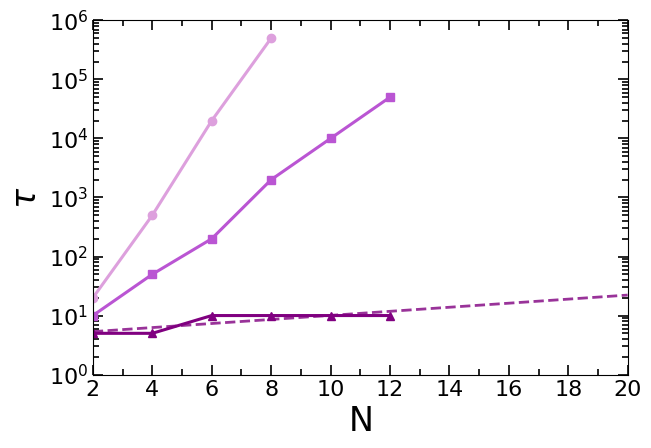

✅ Discord 通知送信 OK
saved: charts/tfim_tau_vs_N_hx0.1-0.2-0.5.pdf


In [37]:
J = 1.0
hx_list = [0.1, 0.2, 0.5]
hxstamp = '-'.join(map(str, hx_list))

# fname = DATADIR / f"tfim_tau_vs_N_hx{hxstamp}"

# dat = np.load(fname)

# データ
hx_list = [0.1, 0.2, 0.5]
N_list = np.linspace(2, 12, 6)
tau_list = [[20, 500, 2e4, 5e5, np.nan, np.nan], [10, 50, 200, 2000, 1e4, 5e4], [5, 5, 10, 10, 10, 10]]
hxstamp = '-'.join(map(str, hx_list))
fig, ax = plt.subplots(figsize=(6.9, 4.6))
inward_ticks(ax)

for i, hx in enumerate(hx_list):
    ax.plot(
        N_list,
        tau_list[i],
        marker=markers[i],
        color=colors_hx[2*i + 1],
        markersize=6.0,
        linewidth=2.2,
    )

# =========================
#  hx = 0.5 を指数関数でフィット
# =========================
hx_target = 0.5
idx = hx_list.index(hx_target)

N_arr   = np.array(N_list, dtype=float)
tau_arr = np.array(tau_list[idx], dtype=float)

# NaN と 0 以下を除外（0 や NaN があると log 取れないので）
mask = np.isfinite(tau_arr) & (tau_arr > 0)
N_fit_data   = N_arr[mask]
tau_fit_data = tau_arr[mask]

# log(τ) = a N + b をフィット → τ = exp(b) * exp(a N)
a, b = np.polyfit(N_fit_data, np.log(tau_fit_data), 1)
A = np.exp(b)  # 前の係数
B = a          # 指数部

print(f"hx={hx_target} フィット結果: τ(N) ≈ {A:.3g} * exp({B:.3g} * N)")

# スムーズな曲線用の N 軸
N_smooth = np.linspace(N_arr.min(), 20, 200)
tau_smooth = A * np.exp(B * N_smooth)

# 元の線と同じ色で、点線で重ねる
fit_color = colors_hx[2 * idx + 1]
ax.plot(
    N_smooth,
    tau_smooth,
    linestyle="--",
    linewidth=2.0,
    color=fit_color,
    alpha=0.8,
)

# hx = 0.1
# 20 500 2e4 5e5 - - 
# hx = 0.2
# 10 50 200 2000 1e4 5e4
# hx = 0.5
# 5 5 10 10 10 10
ax.set_xlim(2, 20)
ax.set_xlabel(r"$\mathrm{N}$", fontsize=24)
ax.set_ylim(1, 1e6)
ax.set_yscale("log")
ax.set_ylabel(r"$\tau$", fontsize=24)

# ax.yaxis.set_major_locator(MultipleLocator())
# ax.yaxis.set_minor_locator(MultipleLocator())
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(1))

plt.show()

notify_discord(message="tfim tau vs N done")
save_fig(fig=fig, stem=f"tfim_tau_vs_N_hx{hxstamp}")
